# Notebook for looking at photon yield / percentage for diff theta, phi

In [1]:
#imports
import numpy as np
import uproot as up
import pandas as pd
import matplotlib.pyplot as plot
from scipy.stats import norm
from scipy.optimize import curve_fit
import sympy
from IPython.display import clear_output
import math
import time
import util
#My imports
from util import PVect,get_layer,create_layer_map,theta_func,phi_func,findBin,bin_percent_theta_phi

Using device cpu


In [ ]:
cworkdir/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/pi/variation_10kevents_file_7.edm4hep.root

In [133]:
particle = "mu"
energy = "5"
color_dict = {
    "pi" : "red",
    "mu" : "blue"
}

uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_17/variation_sensor/mu_variation_10kevents_file_1.edm4hep.root:events"
# uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_13/variation/full_{particle}_{energy}GeV_10k.edm4hep.root:events"
# uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_21/variation_scint/{particle}_{energy}GeV_1000events_file_0.edm4hep.root:events"
# uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_14/variation/full_{particle}_{energy}GeV_1000.edm4hep.root:events"
events = up.open(uproot_path)

x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
z_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.z"].array(library='np')
EDep_branch = events["HcalBarrelHits.EDep"].array(library='np')
Pathlength_branch = events["HcalBarrelHits.pathLength"].array(library='np')
Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
MC_parents = events["_MCParticles_parents.index"].array(library='np')
MC_daughters = events["MCParticles.daughters_end"].array(library='np')
PDG_branch = events["MCParticles.PDG"].array(library='np')
MC_endpoint_x_branch = events["MCParticles.endpoint.x"].array(library='np')

time_branch = events["HcalBarrelHits.time"].array(library='np')
layer_map = [1830.8000, 1841.4000, 1907.5, 1918.1,1984.1999, 1994.8000, 2060.8999,2071.5,2137.6001,2148.1999,2214.3000,2224.8999,2291,2301.6001,2367.6999,2378.3000,2444.3999,2455,2521.1001,2531.6999,2597.8000,2608.3999,2674.5,2685.1001,2751.1999,2761.8000,2827.8999,2838.5]    

MC_px = events["MCParticles.momentum.x"].array(library='np')
MC_py = events["MCParticles.momentum.y"].array(library='np')
MC_pz = events["MCParticles.momentum.z"].array(library='np')
MC_m = events["MCParticles.mass"].array(library='np')
MC_vertex_x = events["MCParticles.vertex.x"].array(library='np')
MC_time_branch = events["MCParticles.time"].array(library='np')

Idea: first find which super layer, then from there test if in first or second layer

In [134]:
layer_map,super_layer_map = create_layer_map()

# photon travel time as function of z hit pos

In [71]:
#calc z hit pos from x pos, px pz
def dz_func(dx, px, pz):
    return dx * pz / px

In [142]:
arrivals = []
for event_idx in range(len(time_branch)):
    if(event_idx > 0):
        break

    print(f"Event #{event_idx}")
    for hit in range(len(EDep_branch[event_idx])):
        time = time_branch[event_idx][hit]
        emission_time = MC_time_branch[event_idx][Hits_MC_idx_branch[event_idx][hit]] 
#         print(f"time difference: {time - emission_time}")
        arrivals.append(time)

Event #0


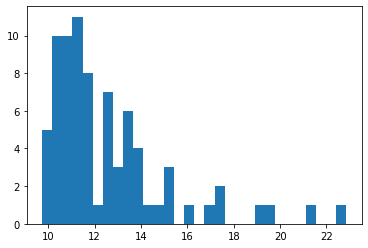

In [147]:
plot.hist(arrivals,bins = 30);
plot.title(f"arrival time, dz")

In [84]:
n_bins = 30

z_min = -770
z_max = 770

z_range = z_max - z_min

z_bins = np.linspace(z_min,z_max,n_bins+1)

z_bin_centers = np.empty(n_bins)
for i in range(len(z_bins) - 1):
    z_bin_centers[i] = (z_bins[i] + z_bins[i+1]) / 2
z_bin_centers_dis = 770 - z_bin_centers    

In [73]:
#works only for evenly spaced bins
def findBin(val,bins):
    diff = bins[1] - bins[0]
    rel_dist = val - bins[0]
    mod = np.floor(rel_dist / diff)
    return int(mod)

In [81]:
time_diff = [[] for i in range(n_bins)]

break_val = 10000
z_counts = np.zeros(n_bins)
for event_idx in range(len(time_branch)):
    if(not (event_idx % (break_val // 100))):
        clear_output(wait = True)
        print(f"{event_idx // (break_val // 100)}% done")
#     if(event_idx > break_val):
#         break
    primary = PVect()
    primary.setVector(MC_px[event_idx][0],MC_py[event_idx][0],MC_pz[event_idx][0],MC_m[event_idx][0])
    dx = 1770 - MC_vertex_x[event_idx][0]  #first layer at approx 1770
    dz = dz_func(dx,primary.px,primary.pz)
    z_bin = findBin(dz,z_bins)
    z_counts[z_bin]+=1
    
    for hit in range(len(EDep_branch[event_idx])):
        #check if hit is from optph
        if(PDG_branch[event_idx][Hits_MC_idx_branch[event_idx][hit]] != -22):
            continue
        hit_time = time_branch[event_idx][hit]
        emission_time = MC_time_branch[event_idx][Hits_MC_idx_branch[event_idx][hit]] 
        time_diff[z_bin].append(hit_time - emission_time)

99% done


In [82]:
time_diff_means = np.empty(len(time_diff))
for i in range(len(time_diff)):
    time_diff_means[i] = sum(time_diff[i]) / len(time_diff[i])

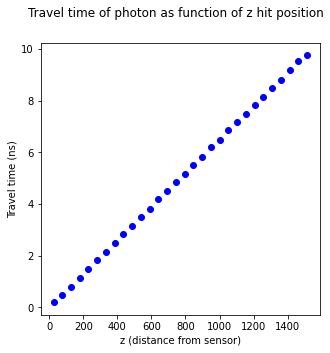

In [85]:
fig, ax1 = plot.subplots(1,1, figsize=(5,5))
fig.suptitle("Travel time of photon as function of z hit position")
ax1.set_ylabel("Travel time (ns)")
ax1.scatter(z_bin_centers_dis,time_diff_means,color = "blue")
ax1.set_xlabel("z (distance from sensor)")
fig.show()
# fig.savefig("plots/percentage/June_14_mu_5GeV_10k_phi_theta_20_bins.jpeg")

In [101]:
def linear(x,m,b):
    return m * x + b

In [111]:
popt_z, pcov_z = curve_fit(linear,z_bin_centers_dis,time_diff_means)
fit_x = np.linspace(25,1500,200)
z_fit = linear(fit_x,*popt_z)
# z_fit = inverse(fit_x,494.98,9.9733,-0.16796)

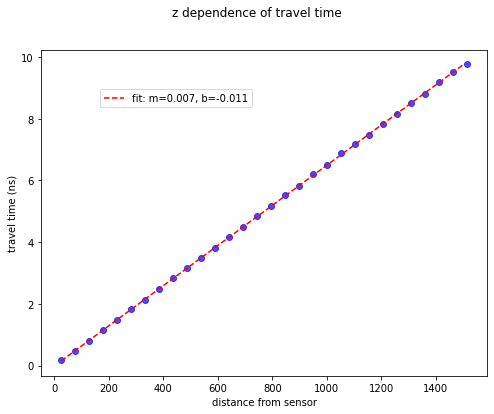

In [115]:
fig_z, ax_z = plot.subplots(1,1, figsize = (8,6))
ax_z.plot(fit_x,z_fit, 'r--',label='fit: m=%5.3f, b=%5.3f' % tuple(popt_z))
fig_z.suptitle("z dependence of travel time")
ax_z.scatter(z_bin_centers_dis,time_diff_means,color="blue", alpha = 0.7)
ax_z.set_xlabel("distance from sensor")
ax_z.set_ylabel("travel time (ns)")
fig_z.legend(bbox_to_anchor=(0.5, 0.8))
fig_z.savefig("plots/time_parameterization/linear.jpeg")

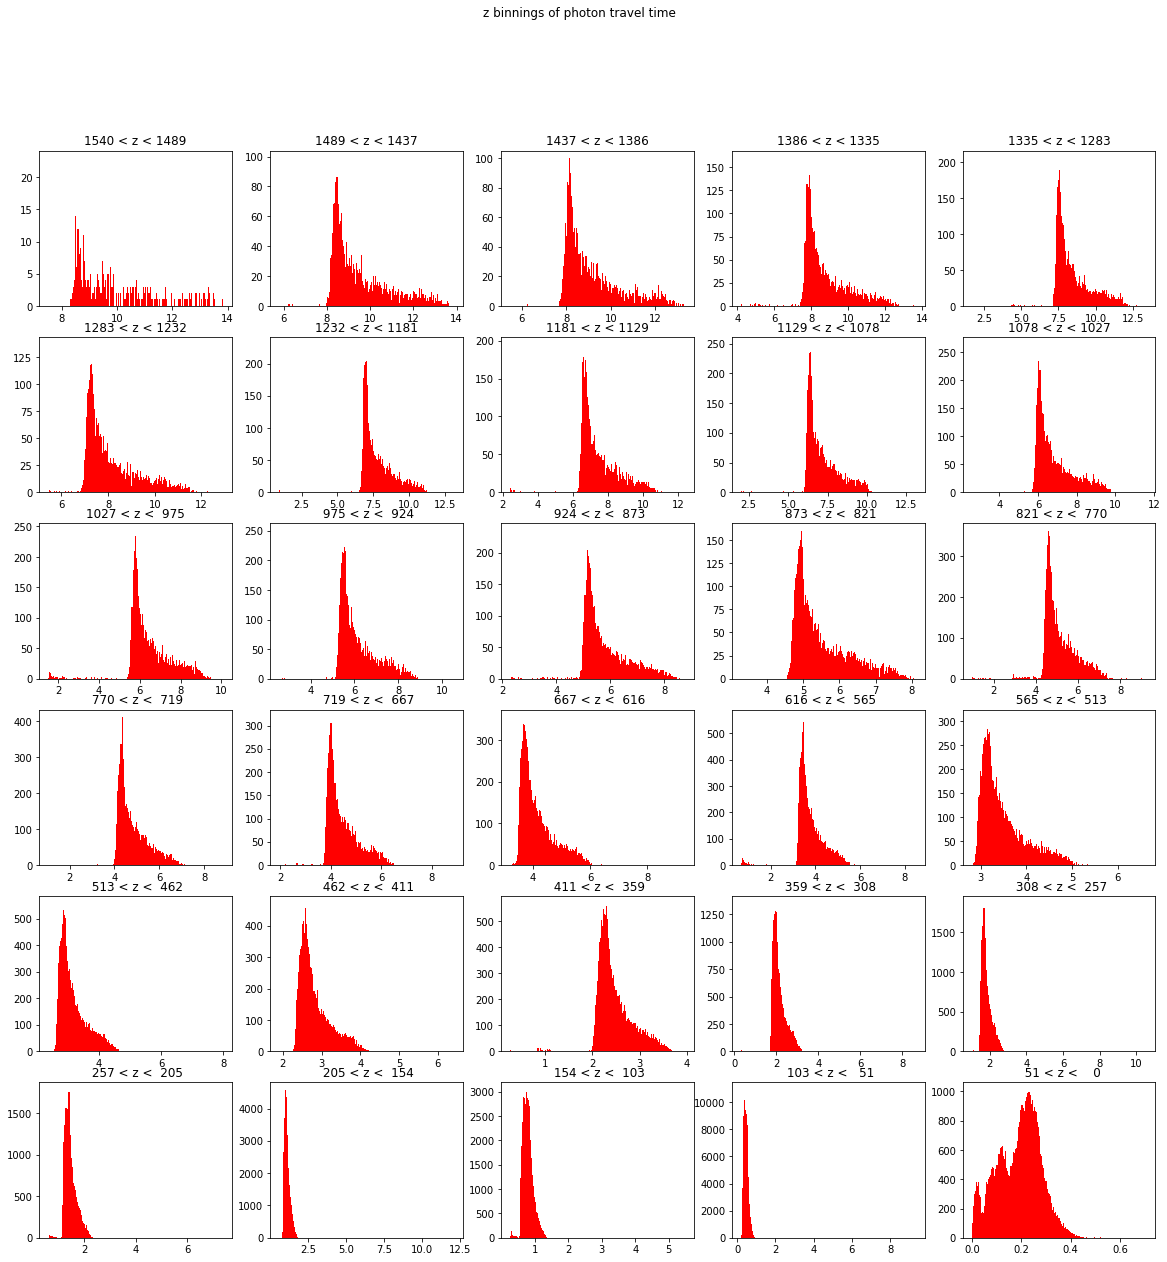

In [140]:
z_bins_dis = 770 - z_bins
fig, axs = plot.subplots(6,5,figsize = (20,20))
fig.suptitle("z binnings of photon travel time")
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].set_title("%4.0f < z < %4.0f"%(z_bins_dis[i * 5 + j],z_bins_dis[i * 5 + j + 1]))
        axs[i,j].hist(time_diff[i * 5 + j], color = 'r', bins = 1000)
fig.savefig("plots/time_parameterization/histos.jpeg")

# Primary energy independent of timing

In [ ]:
n_bins = 20

e_min = 0.4
e_max = 10.1

e_range = e_max - e_min

e_bins = np.linspace(e_min,e_max,n_bins+1)

e_bin_centers = np.empty(n_bins)
for i in range(len(e_bins) - 1):
    e_bin_centers[i] = (e_bins[i] + e_bins[i+1]) / 2

In [ ]:
time_diff = [[] for i in range(n_bins)]

break_val = 10000
e_counts = np.zeros(n_bins)
for event_idx in range(len(time_branch)):
    if(not (event_idx % (break_val // 100))):
        clear_output(wait = True)
        print(f"{event_idx // (break_val // 100)}% done")
    if(event_idx > break_val):
        break
    primary = PVect()
    primary.setVector(MC_px[event_idx][0],MC_py[event_idx][0],MC_pz[event_idx][0],MC_m[event_idx][0])
    e_bin = findBin(primary.E,e_bins)
    e_counts[e_bin]+=1
    
    for hit in range(len(EDep_branch[event_idx])):
        #check if hit is from optph
        if(PDG_branch[event_idx][Hits_MC_idx_branch[event_idx][hit]] != -22):
            continue
        hit_time = time_branch[event_idx][hit]
        emission_time = MC_time_branch[event_idx][Hits_MC_idx_branch[event_idx][hit]] 
        time_diff[e_bin].append(hit_time - emission_time)

In [57]:
time_diff_means = np.empty(len(time_diff))
for i in range(len(time_diff)):
    if(not len(time_diff[i])):
        time_diff_means[i] = -5
        continue
    time_diff_means[i] = sum(time_diff[i]) / len(time_diff[i])

In [ ]:
fig, ax1 = plot.subplots(1,1, figsize=(5,5))
fig.suptitle("Travel time of photon as function of primary energy")
ax1.set_ylabel("Travel time (ns)")
ax1.scatter(e_bin_centers,time_diff_means,color = "blue")
ax1.set_xlabel("primary energy (GeV)")
ax1.set_xlim(0.4,10.1)
ax1.set_ylim(0,4)
fig.show()
fig.savefig("plots/time_parameterization/travel_time_energy_10k_20_bins.jpeg")

In [ ]:
fig, axs = plot.subplots(4,5,figsize = (20,15))
fig.suptitle("E binnings of photon travel time")
for i in range(axs.shape[0]):
    n_columns = axs.shape[1]
    for j in range(n_columns):
        axs[i,j].set_title("%4.2f < E < %4.2f"%(e_bins[i * 5 + j],e_bins[i * 5 + j + 1]))
        axs[i,j].hist(time_diff[i * 5 + j], color = 'r', bins = 1000)
fig.savefig("plots/time_parameterization/histos_travel_time_energy_10k_20_bins.jpeg")

# Energy deposited independent of timing

In [138]:
n_bins = 20

np_min = 10000
np_max = 50000

np_range = np_max - np_min

np_bins = np.linspace(np_min,np_max,n_bins+1)

np_bin_centers = np.empty(n_bins)
for i in range(len(np_bins) - 1):
    np_bin_centers[i] = (np_bins[i] + np_bins[i+1]) / 2

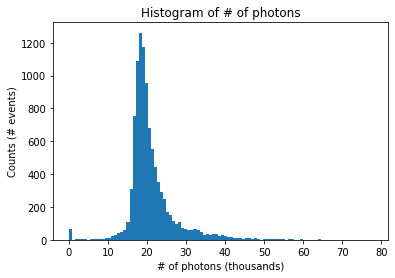

In [148]:
num_photons = np.empty(len(PDG_branch))
for i in range(len(PDG_branch)):
    num_photons[i] = np.asarray(np.where(PDG_branch[i] == -22, 1, 0)).sum()
plot.hist(num_photons / 1000,bins = 100);
plot.title("Histogram of # of photons")
plot.xlabel("# of photons (thousands)")
plot.ylabel("Counts (# events)")
plot.savefig("plots/time_parameterization/num_photons_histo.jpeg")

In [146]:
time_diff = [[] for i in range(n_bins)]

break_val = 10000
np_counts = np.zeros(n_bins)
skipped = 0
for event_idx in range(len(time_branch)):
    num_photons = 0
    if(not (event_idx % (break_val // 100))):
        clear_output(wait = True)
        print(f"{event_idx // (break_val // 100)}% done")
    if(event_idx > break_val):
        break
    num_photons = np.where(PDG_branch[event_idx] == -22, 1, 0).sum()
    np_bin = findBin(num_photons,np_bins)
    if(np_bin > 19):
        skipped += 1
#         print(np_bin)
        continue
    np_counts[np_bin]+=1
    for hit in range(len(EDep_branch[event_idx])):
        #check if hit is from optph
        if(PDG_branch[event_idx][Hits_MC_idx_branch[event_idx][hit]] != -22):
            continue
        hit_time = time_branch[event_idx][hit]
        emission_time = MC_time_branch[event_idx][Hits_MC_idx_branch[event_idx][hit]] 
        time_diff[np_bin].append(hit_time - emission_time)
print(f"skipped {skipped} events")

99% done
skipped 40 events


In [149]:
time_diff_means = np.empty(len(time_diff))
for i in range(len(time_diff)):
    if(not len(time_diff[i])):
        time_diff_means[i] = -5
        continue
    time_diff_means[i] = sum(time_diff[i]) / len(time_diff[i])

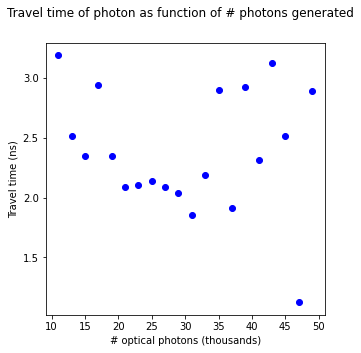

In [151]:
fig, ax1 = plot.subplots(1,1, figsize=(5,5))
fig.suptitle("Travel time of photon as function of # photons generated")
ax1.set_ylabel("Travel time (ns)")
ax1.scatter(np_bin_centers // 1000,time_diff_means,color = "blue")
ax1.set_xlabel("# optical photons (thousands)")
fig.show()
fig.savefig("plots/time_parameterization/travel_time_num_photons_10k_20_bins.jpeg")

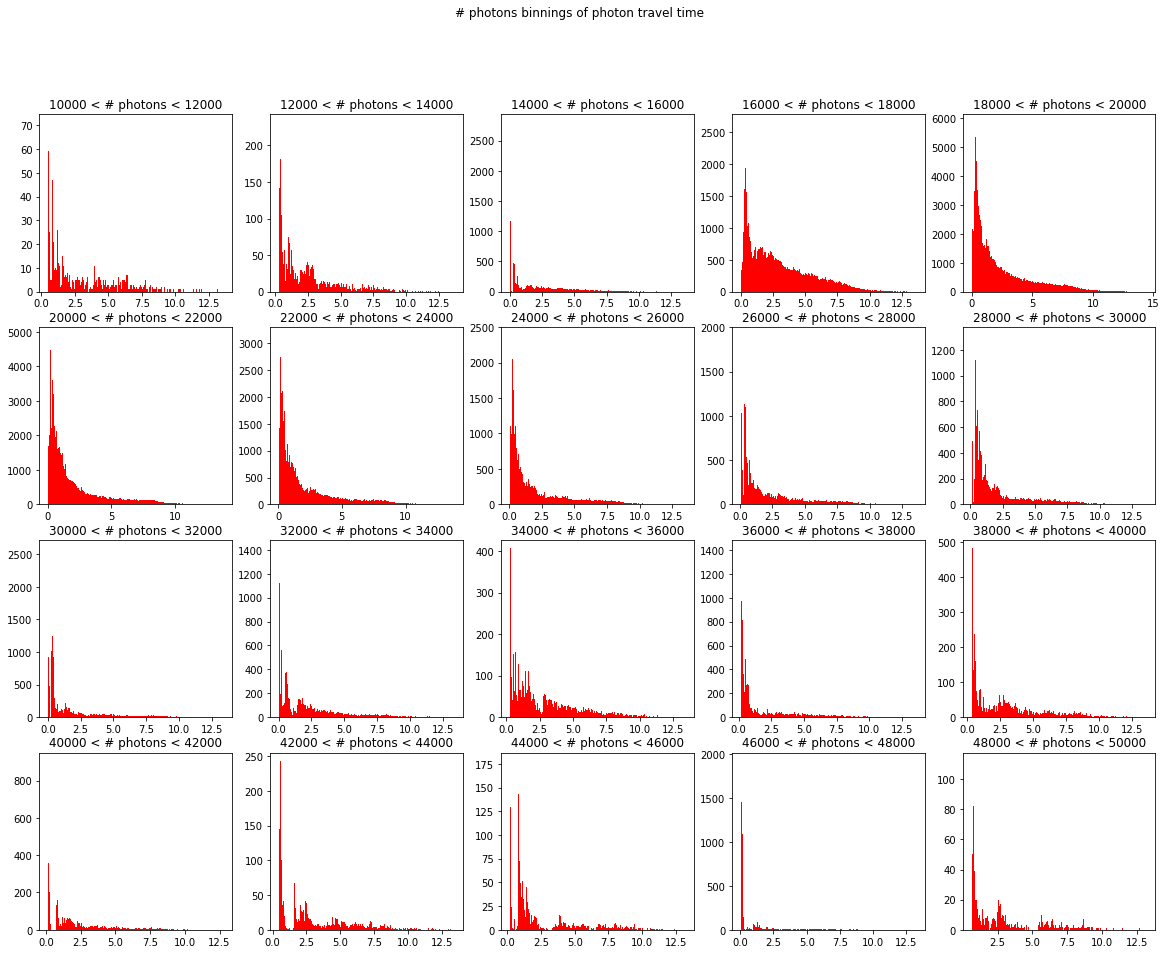

In [153]:
fig, axs = plot.subplots(4,5,figsize = (20,15))
fig.suptitle("# photons binnings of photon travel time")
for i in range(axs.shape[0]):
    n_columns = axs.shape[1]
    for j in range(n_columns):
        axs[i,j].set_title("%4.0f < # photons < %4.0f"%(np_bins[i * 5 + j],np_bins[i * 5 + j + 1]))
        axs[i,j].hist(time_diff[i * 5 + j], color = 'r', bins = 1000)
fig.savefig("plots/time_parameterization/histos_travel_time_num_photons_10k_20_bins.jpeg")